In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
import gym_anytrading
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim



In [2]:
class ActorCritic(nn.Module):
    def __init__(self, input_dim, n_actions):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions),
            nn.Softmax(dim=-1)
        )
        
        self.critic = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, state):
        probs = self.actor(state)
        value = self.critic(state)
        return probs, value
    
    
def compute_loss(log_probs, values, rewards, gamma):
    # Compute returns and advantage
    returns = []
    Gt = 0
    pw = 0
    for reward in reversed(rewards):
        Gt = reward + gamma ** pw * Gt
        returns.insert(0, Gt)
        pw += 1
    
    log_probs = torch.stack(log_probs)
    returns = torch.tensor(returns)
    values = torch.cat(values)
    
    advantage = returns - values
    actor_loss = -(log_probs * advantage).mean()
    critic_loss = advantage.pow(2).mean()
    
    return actor_loss, critic_loss



In [3]:
def train(env, model, episode, T, actor_lr=0.01, critic_lr=0.05, gamma=0.99):
    state, _ = env.reset()
    
    
    log_probs = []
    values = []
    rewards = []
    episode_reward = 0

    for t in range(T):
        state = state.flatten()
        state = torch.tensor([state], dtype=torch.float32)
        
        probs, value = model(state)
        distribution = torch.distributions.Categorical(probs)
        action = distribution.sample()
        next_state, reward, terminated, truncated, info = env.step(action.item())
        done = terminated or truncated
        
        log_prob = distribution.log_prob(action)
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(reward)
        episode_reward += reward
        if done:
            #print(f"Episode {episode} finished with total reward {episode_reward}")
            break
        state = next_state
    actor_loss, critic_loss = compute_loss(log_probs, values, rewards, gamma)
    
    for param in model.actor.parameters():
        if param.grad is not None:
            param.grad.data.zero_()
    actor_loss.backward(retain_graph=True)
    
    for param in model.actor.parameters():
        param.data -= actor_lr * param.grad.data
        
    
    for param in model.critic.parameters():
        if param.grad is not None:
            param.grad.data.zero_()
    critic_loss.backward()
    for param in model.critic.parameters():
        param.data -= critic_lr * param.grad.data
    
    return episode_reward, info


In [4]:
env = gym.make('forex-v0', frame_bound=(10, 500), window_size=10)
input_dim = env.observation_space.shape[1] * env.observation_space.shape[0]
n_actions = env.action_space.n

model = ActorCritic(input_dim, n_actions)
optimizer = optim.Adam(model.parameters(), lr=0.001)
T = env.frame_bound[1] - env.frame_bound[0]

num_episodes = 300
for episode in range(num_episodes):
    reward, info = train(env, model, episode, T)
    print(f"Episode: {episode+1}, Reward: {reward}")
    print("info: ", info)
    print()

/Users/ryankan/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.frame_bound` for environment variables or `env.get_attr('frame_bound')` that will search the reminding wrappers.
  logger.warn(
/var/folders/jv/c7kjn4v159b6c6q5vxtjnp_w0000gn/T/ipykernel_54461/1841575082.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  state = torch.tensor([state], dtype=torch.float32)


Episode: 1, Reward: 419.91472244262695
info:  {'total_reward': 419.91472244262695, 'total_profit': 0.9778849731618555, 'position': <Positions.Long: 1>}

Episode: 2, Reward: -108.92629623413086
info:  {'total_reward': -108.92629623413086, 'total_profit': 0.9568476626620055, 'position': <Positions.Long: 1>}

Episode: 3, Reward: -591.505765914917
info:  {'total_reward': -591.505765914917, 'total_profit': 0.9279385012137207, 'position': <Positions.Short: 0>}

Episode: 4, Reward: -28.107166290283203
info:  {'total_reward': -28.107166290283203, 'total_profit': 0.9563363420765524, 'position': <Positions.Long: 1>}

Episode: 5, Reward: -274.6927738189697
info:  {'total_reward': -274.6927738189697, 'total_profit': 0.9441354789482208, 'position': <Positions.Short: 0>}

Episode: 6, Reward: -465.11173248291016
info:  {'total_reward': -465.11173248291016, 'total_profit': 0.9359497541178132, 'position': <Positions.Short: 0>}

Episode: 7, Reward: -38.307905197143555
info:  {'total_reward': -38.3079051

Episode: 55, Reward: 394.4993019104004
info:  {'total_reward': 394.4993019104004, 'total_profit': 0.975734809372735, 'position': <Positions.Short: 0>}

Episode: 56, Reward: 223.50788116455078
info:  {'total_reward': 223.50788116455078, 'total_profit': 0.9696381270368486, 'position': <Positions.Short: 0>}

Episode: 57, Reward: -229.29906845092773
info:  {'total_reward': -229.29906845092773, 'total_profit': 0.9486855870635656, 'position': <Positions.Short: 0>}

Episode: 58, Reward: 182.68942832946777
info:  {'total_reward': 182.68942832946777, 'total_profit': 0.9688425864079561, 'position': <Positions.Long: 1>}

Episode: 59, Reward: 155.09605407714844
info:  {'total_reward': 155.09605407714844, 'total_profit': 0.9641468634746578, 'position': <Positions.Long: 1>}

Episode: 60, Reward: -185.69707870483398
info:  {'total_reward': -185.69707870483398, 'total_profit': 0.9517324390028705, 'position': <Positions.Long: 1>}

Episode: 61, Reward: 240.09943008422852
info:  {'total_reward': 240.0994

Episode: 109, Reward: -63.109397888183594
info:  {'total_reward': -63.109397888183594, 'total_profit': 0.9559580453571911, 'position': <Positions.Long: 1>}

Episode: 110, Reward: 325.1171112060547
info:  {'total_reward': 325.1171112060547, 'total_profit': 0.9732573921122467, 'position': <Positions.Long: 1>}

Episode: 111, Reward: -180.11093139648438
info:  {'total_reward': -180.11093139648438, 'total_profit': 0.949409254526269, 'position': <Positions.Short: 0>}

Episode: 112, Reward: 85.10470390319824
info:  {'total_reward': 85.10470390319824, 'total_profit': 0.9612865903968117, 'position': <Positions.Long: 1>}

Episode: 113, Reward: 93.89877319335938
info:  {'total_reward': 93.89877319335938, 'total_profit': 0.962532215501142, 'position': <Positions.Long: 1>}

Episode: 114, Reward: -828.2947540283203
info:  {'total_reward': -828.2947540283203, 'total_profit': 0.9192466907793844, 'position': <Positions.Long: 1>}

Episode: 115, Reward: -122.88808822631836
info:  {'total_reward': -122.88

Episode: 162, Reward: 144.49357986450195
info:  {'total_reward': 144.49357986450195, 'total_profit': 0.9663343410686104, 'position': <Positions.Long: 1>}

Episode: 163, Reward: -58.28738212585449
info:  {'total_reward': -58.28738212585449, 'total_profit': 0.9551904715799066, 'position': <Positions.Short: 0>}

Episode: 164, Reward: -442.28434562683105
info:  {'total_reward': -442.28434562683105, 'total_profit': 0.9389874572684941, 'position': <Positions.Long: 1>}

Episode: 165, Reward: -422.0759868621826
info:  {'total_reward': -422.0759868621826, 'total_profit': 0.9403913175309233, 'position': <Positions.Long: 1>}

Episode: 166, Reward: -12.927055358886719
info:  {'total_reward': -12.927055358886719, 'total_profit': 0.9575803946304852, 'position': <Positions.Short: 0>}

Episode: 167, Reward: -264.10579681396484
info:  {'total_reward': -264.10579681396484, 'total_profit': 0.9454618169892617, 'position': <Positions.Short: 0>}

Episode: 168, Reward: -105.8816909790039
info:  {'total_rewar

Episode: 215, Reward: 317.49725341796875
info:  {'total_reward': 317.49725341796875, 'total_profit': 0.9720172716106549, 'position': <Positions.Long: 1>}

Episode: 216, Reward: -25.90656280517578
info:  {'total_reward': -25.90656280517578, 'total_profit': 0.9567896506260855, 'position': <Positions.Long: 1>}

Episode: 217, Reward: 54.090023040771484
info:  {'total_reward': 54.090023040771484, 'total_profit': 0.9601846488335212, 'position': <Positions.Short: 0>}

Episode: 218, Reward: 565.2952194213867
info:  {'total_reward': 565.2952194213867, 'total_profit': 0.9864947786724427, 'position': <Positions.Short: 0>}

Episode: 219, Reward: -423.504114151001
info:  {'total_reward': -423.504114151001, 'total_profit': 0.9383923407792135, 'position': <Positions.Long: 1>}

Episode: 220, Reward: -40.68732261657715
info:  {'total_reward': -40.68732261657715, 'total_profit': 0.9575124261681083, 'position': <Positions.Short: 0>}

Episode: 221, Reward: 293.1046485900879
info:  {'total_reward': 293.104

Episode: 268, Reward: -173.1109619140625
info:  {'total_reward': -173.1109619140625, 'total_profit': 0.9517033978727643, 'position': <Positions.Long: 1>}

Episode: 269, Reward: -463.0887508392334
info:  {'total_reward': -463.0887508392334, 'total_profit': 0.9395425594931391, 'position': <Positions.Long: 1>}

Episode: 270, Reward: 171.30613327026367
info:  {'total_reward': 171.30613327026367, 'total_profit': 0.9630224086304227, 'position': <Positions.Long: 1>}

Episode: 271, Reward: 49.326419830322266
info:  {'total_reward': 49.326419830322266, 'total_profit': 0.961053376212253, 'position': <Positions.Short: 0>}

Episode: 272, Reward: 288.10739517211914
info:  {'total_reward': 288.10739517211914, 'total_profit': 0.9685484309544848, 'position': <Positions.Long: 1>}

Episode: 273, Reward: -290.297269821167
info:  {'total_reward': -290.297269821167, 'total_profit': 0.9473341282223072, 'position': <Positions.Short: 0>}

Episode: 274, Reward: 430.4993152618408
info:  {'total_reward': 430.499

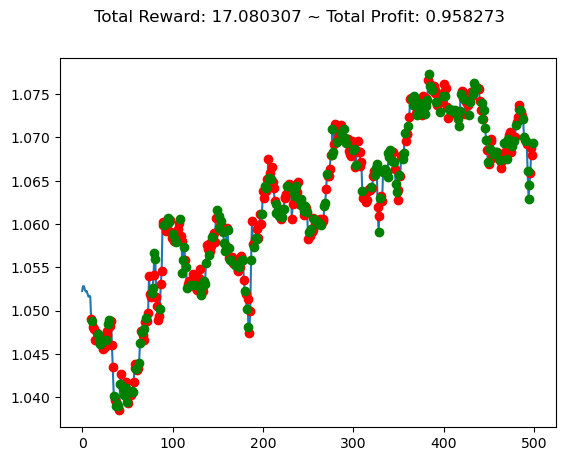

In [5]:
plt.cla()
env.unwrapped.render_all()
plt.show()
